# JULIA FLUX CODE

In [8]:
using Pkg
#Pkg.add("Flux")
#Pkg.add("MLDatasets")
#Pkg.add("Parameters")
#Pkg.add("Revise")
#Pkg.add("CUDA")
using Flux
using Parameters
using Base.Iterators: partition
using Plots
using CUDA
using MLDatasets

In [9]:
#This little bit of code is used in all of the Model Zoo examples as a way to test whether you have
# cuda gpu support. If so, CuArrays is imported and we will process our model on the GPU
if has_cuda()
    @info "CUDA is on"
    import CUDA
    CUDA.allowscalar(false)
end

┌ Info: CUDA is on
└ @ Main In[9]:4


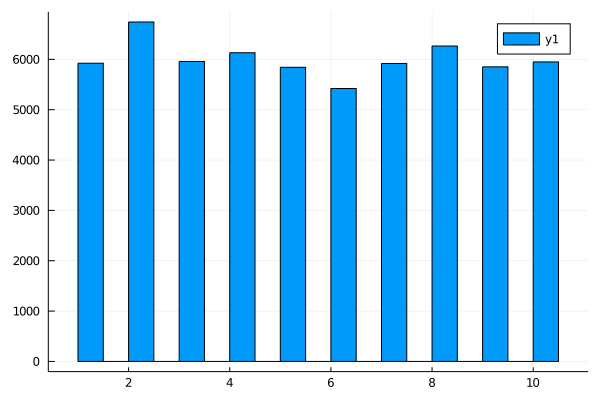

The frustrating thing about learning deep learning models is that the architecture seems arbitrary.  Why Relu? Why a layer of that particular width? It turns out, that people just try things out and report their performance. Things that perform well get copied. Sometimes, people optimize over certain parameters using crossval and LOTS of compute. When things work, they get repeated. It's a mix of empirical results for particular datasets and heuristic approaches.

Take for example the code from Flux.jl model zoon on convolutional NN for MNIST.. Why did they choose their layers the way the did? Why max pools at each layer? no explanation. Just works.

Generally, when I'm coding a neural network, I organize my code procedurally in the following steps:
1. Import and process data into necessary data sets
2. Construct NN model
3. Specify loss function
4. Create function to process training data
5. Create function to perform validation
6. Create function to perform estimate test performance
7. Perform training
8. Perform Validation
9. Perform estimation of test performance
10. If satisfied with model hyperparameters and test set performance, train model on entire data set and save. This is your model for deployment.

In [12]:
# Lets create a struct to store our model arguments
# This will help organize our code and allow arguments to be passed into our functions in a clean and readable manner

# The @with_kw creates a constructor for our args type automatically
@with_kw mutable struct Args
    η::Float64 = 3e-3
    epochs::Int = 1
    batch_size = 50
    savepath::String = "./"
    device::Function = gpu
    imgsize::Tuple = (28,28,1)
    nclasses::Int = 10
end

Args

I finally figured out why I was getting errors! You have to be careful with the dimensions of the dataset. In one of the modelzoo examples, they pull data using a DataLoader with MLDatasets.MNIST, with the other example they use Flux.Data.MNIST.  The dimensions of each are different. Also, they were flattening the data.

After undoing the transformations and examinging the dimensions of the data, all that was required was converting a 28x28xN dataset into a 28x28x1xN.  The additional dimension made the dimensions match with the model params dimensions and everything began to work again.

Dimensions matter, I wont forget it. I've been debugging this model for a full day!

In [105]:
#Define a function to get data
function getdata(args)
    # Loading Dataset
    xtrain, ytrain = MLDatasets.MNIST.traindata(Float32)
    xtest, ytest = MLDatasets.MNIST.testdata(Float32)

    # Reshape Data from 28x28xN to 28x28x1xN, not that this only works for the convolutional model
    xtrain = reshape(xtrain,size(xtrain)[1:2]...,1,size(xtrain)[3])
    xtest = reshape(xtest,size(xtest)[1:2]...,1,size(xtest)[3])

    # One-hot-encode the labels
    ytrain, ytest = Flux.onehotbatch(ytrain, 0:9), Flux.onehotbatch(ytest, 0:9)

    # Batching
    train_data = Flux.Data.DataLoader(xtrain, ytrain, batchsize=args.batch_size, shuffle=true)
    test_data = Flux.Data.DataLoader(xtest, ytest, batchsize=args.batch_size)
    return train_data, test_data
end

getdata (generic function with 1 method)

In [68]:
function build_model(args)
    return Chain(Dense(prod(args.imgsize),32,relu),
            Dense(32,args.nclasses))
end

function build_conv_model(args)
    cnn_output_size = Int.(floor.([args.imgsize[1]/8,args.imgsize[2]/8,32]))
    return Chain(
    # First convolution, operating upon a 28x28 image
    Conv((3, 3), 1=>16, pad=(1,1), relu),
    MaxPool((2,2)),

    # Second convolution, operating upon a 14x14 image
    Conv((3, 3), 16=>32, pad=(1,1), relu),
    MaxPool((2,2)),

    # Third convolution, operating upon a 7x7 image
    Conv((3, 3), 32=>32, pad=(1,1), relu),
    MaxPool((2,2)),

    # Reshape 3d tensor into a 2d one using `Flux.flatten`, at this point it should be (3, 3, 32, N)
    flatten,
    Dense(prod(cnn_output_size), 10))
end



build_conv_model (generic function with 1 method)

In [158]:
function loss_all(dataloader, model)
    l = 0f0
    for (x,y) in dataloader

        l += Flux.Losses.logitcrossentropy(model(x), y)
    end
    l/length(dataloader)
end

function accuracy(data_loader, model)
    acc = 0
    for (x,y) in data_loader
        acc += sum(Flux.onecold(cpu(model(x))) .== Flux.onecold(cpu(y)))*1 / size(x,4)
    end
    acc/length(data_loader)
end

accuracy (generic function with 1 method)

In [160]:
args = Args(;epochs =5,batch_size=1000)
# Construct model
m = build_conv_model(args)
train_data,test_data = getdata(args)
train_data = args.device.(train_data)
test_data = args.device.(test_data)
m = args.device(m)
loss(x,y) = Flux.Losses.logitcrossentropy(m(x), y)

## Training
evalcb = () -> @show(loss_all(train_data, m))
opt = ADAM(args.η)

Flux.@epochs args.epochs Flux.train!(loss, params(m), train_data, opt, cb = evalcb)

@show accuracy(train_data, m)

@show accuracy(test_data, m)


┌ Info: Epoch 1
└ @ Main C:\Users\Bleep\.julia\packages\Flux\05b38\src\optimise\train.jl:114


loss_all(train_data, m) = 2.2776525f0
loss_all(train_data, m) = 2.248435f0
loss_all(train_data, m) = 2.2152865f0
loss_all(train_data, m) = 2.1728847f0
loss_all(train_data, m) = 2.1165485f0
loss_all(train_data, m) = 2.0444007f0
loss_all(train_data, m) = 1.9534538f0
loss_all(train_data, m) = 1.839233f0
loss_all(train_data, m) = 1.7029536f0
loss_all(train_data, m) = 1.5498775f0
loss_all(train_data, m) = 1.3873558f0
loss_all(train_data, m) = 1.2115502f0
loss_all(train_data, m) = 1.0439117f0
loss_all(train_data, m) = 0.8958241f0
loss_all(train_data, m) = 0.7873061f0
loss_all(train_data, m) = 0.69131976f0
loss_all(train_data, m) = 0.62354285f0
loss_all(train_data, m) = 0.5629688f0
loss_all(train_data, m) = 0.5218593f0
loss_all(train_data, m) = 0.49033296f0
loss_all(train_data, m) = 0.4573032f0
loss_all(train_data, m) = 0.44973817f0
loss_all(train_data, m) = 0.41917577f0
loss_all(train_data, m) = 0.40969753f0
loss_all(train_data, m) = 0.366155f0
loss_all(train_data, m) = 0.3984281f0
loss_all(

┌ Info: Epoch 2
└ @ Main C:\Users\Bleep\.julia\packages\Flux\05b38\src\optimise\train.jl:114


loss_all(train_data, m) = 0.17277148f0
loss_all(train_data, m) = 0.17605901f0
loss_all(train_data, m) = 0.16929227f0
loss_all(train_data, m) = 0.16183974f0
loss_all(train_data, m) = 0.16953257f0
loss_all(train_data, m) = 0.15832387f0
loss_all(train_data, m) = 0.14549473f0
loss_all(train_data, m) = 0.15611799f0
loss_all(train_data, m) = 0.16809325f0
loss_all(train_data, m) = 0.15138428f0
loss_all(train_data, m) = 0.1408373f0
loss_all(train_data, m) = 0.14237304f0
loss_all(train_data, m) = 0.14286514f0
loss_all(train_data, m) = 0.14565895f0
loss_all(train_data, m) = 0.14595693f0
loss_all(train_data, m) = 0.13978532f0
loss_all(train_data, m) = 0.13584372f0
loss_all(train_data, m) = 0.1364515f0
loss_all(train_data, m) = 0.1331088f0
loss_all(train_data, m) = 0.12994474f0
loss_all(train_data, m) = 0.13306803f0
loss_all(train_data, m) = 0.13463661f0
loss_all(train_data, m) = 0.12684658f0
loss_all(train_data, m) = 0.12401478f0
loss_all(train_data, m) = 0.12391225f0
loss_all(train_data, m) = 0.

┌ Info: Epoch 3
└ @ Main C:\Users\Bleep\.julia\packages\Flux\05b38\src\optimise\train.jl:114


loss_all(train_data, m) = 0.099982806f0
loss_all(train_data, m) = 0.108037524f0
loss_all(train_data, m) = 0.113099895f0
loss_all(train_data, m) = 0.10078212f0
loss_all(train_data, m) = 0.101065464f0
loss_all(train_data, m) = 0.10426667f0
loss_all(train_data, m) = 0.09523626f0
loss_all(train_data, m) = 0.09512427f0
loss_all(train_data, m) = 0.10730527f0
loss_all(train_data, m) = 0.09919824f0
loss_all(train_data, m) = 0.08822267f0
loss_all(train_data, m) = 0.09600993f0
loss_all(train_data, m) = 0.09792208f0
loss_all(train_data, m) = 0.09450543f0
loss_all(train_data, m) = 0.094810806f0
loss_all(train_data, m) = 0.09030684f0
loss_all(train_data, m) = 0.08977219f0
loss_all(train_data, m) = 0.09186118f0
loss_all(train_data, m) = 0.095904894f0
loss_all(train_data, m) = 0.090484954f0
loss_all(train_data, m) = 0.086523674f0
loss_all(train_data, m) = 0.09238333f0
loss_all(train_data, m) = 0.091473594f0
loss_all(train_data, m) = 0.088602796f0
loss_all(train_data, m) = 0.087422095f0
loss_all(train

┌ Info: Epoch 4
└ @ Main C:\Users\Bleep\.julia\packages\Flux\05b38\src\optimise\train.jl:114


loss_all(train_data, m) = 0.07572326f0
loss_all(train_data, m) = 0.080911025f0
loss_all(train_data, m) = 0.08440767f0
loss_all(train_data, m) = 0.0791189f0
loss_all(train_data, m) = 0.0748353f0
loss_all(train_data, m) = 0.077109165f0
loss_all(train_data, m) = 0.07513511f0
loss_all(train_data, m) = 0.07174246f0
loss_all(train_data, m) = 0.07603264f0
loss_all(train_data, m) = 0.07951641f0
loss_all(train_data, m) = 0.07171177f0
loss_all(train_data, m) = 0.0679686f0
loss_all(train_data, m) = 0.070156656f0
loss_all(train_data, m) = 0.074707836f0
loss_all(train_data, m) = 0.076179735f0
loss_all(train_data, m) = 0.071818344f0
loss_all(train_data, m) = 0.07066049f0
loss_all(train_data, m) = 0.07075668f0
loss_all(train_data, m) = 0.07220874f0
loss_all(train_data, m) = 0.074729f0
loss_all(train_data, m) = 0.07058056f0
loss_all(train_data, m) = 0.068514705f0
loss_all(train_data, m) = 0.06803015f0
loss_all(train_data, m) = 0.07101832f0
loss_all(train_data, m) = 0.07264062f0
loss_all(train_data, m)

┌ Info: Epoch 5
└ @ Main C:\Users\Bleep\.julia\packages\Flux\05b38\src\optimise\train.jl:114


loss_all(train_data, m) = 0.065258905f0
loss_all(train_data, m) = 0.06945584f0
loss_all(train_data, m) = 0.06427868f0
loss_all(train_data, m) = 0.05975722f0
loss_all(train_data, m) = 0.05984291f0
loss_all(train_data, m) = 0.059782997f0
loss_all(train_data, m) = 0.05778915f0
loss_all(train_data, m) = 0.058370486f0
loss_all(train_data, m) = 0.061772455f0
loss_all(train_data, m) = 0.061132055f0
loss_all(train_data, m) = 0.05827368f0
loss_all(train_data, m) = 0.055853672f0
loss_all(train_data, m) = 0.057137605f0
loss_all(train_data, m) = 0.06007219f0
loss_all(train_data, m) = 0.060703333f0
loss_all(train_data, m) = 0.06133113f0
loss_all(train_data, m) = 0.060369495f0
loss_all(train_data, m) = 0.056733675f0
loss_all(train_data, m) = 0.057668015f0
loss_all(train_data, m) = 0.05788345f0
loss_all(train_data, m) = 0.057998262f0
loss_all(train_data, m) = 0.056284603f0
loss_all(train_data, m) = 0.056328926f0
loss_all(train_data, m) = 0.058143124f0
loss_all(train_data, m) = 0.05863417f0
loss_all(t

0.9832999999999998

1000
1000
1000
1000
1000
1000
1000
1000
1000
1000


In [159]:
accuracy(test_data,m)

0.9855

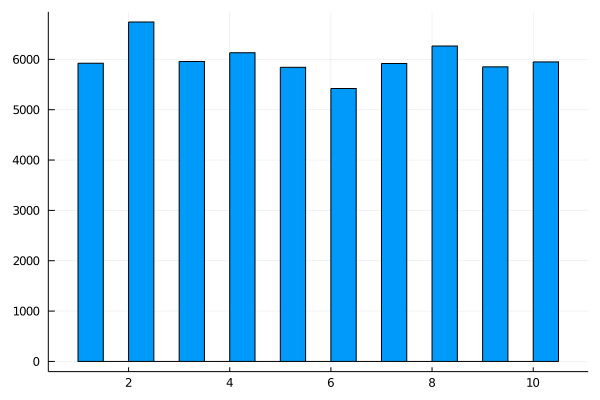

In [112]:
histogram(Flux.onecold(ytrain), leg=false)

In [113]:
m = build_conv_model(args)
for row in params(m)
    @show size(row)
end

size(row) = (3, 3, 1, 16)
size(row) = (16,)
size(row) = (3, 3, 16, 32)
size(row) = (32,)
size(row) = (3, 3, 32, 32)
size(row) = (32,)
size(row) = (10, 288)
size(row) = (10,)
